# 3.线性回归模型

#### 3.1.1.4 小批量梯度下降
在每次需要计算更新的时候随机抽取一小批样本，进行小批量随机梯度下降

## 3.2 线性回归 手动实现

In [1]:
import random
import torch
from d2l import torch as d2l
%matplotlib inline

### 3.2.1 生成数据集

In [13]:
def synthetic_data(b, w, num_examples):
    X = torch.normal(0 ,1, (num_examples, len(w)))
    #返回一个张量,均值是0，平均数是1的正态分布
    y = torch.matmul(X, w) + b#这里不能用mm
    print(X.shape, w.shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [15]:
true_b = 4.2
true_w = torch.tensor([2, -3.4])
features, labels = synthetic_data(true_b, true_w, 1000)


torch.Size([1000, 2]) torch.Size([2])


注意 features每一行都包含一个二维数据样本 labels每一行都包含一个标量

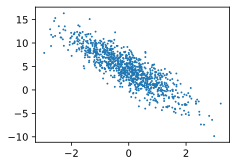

In [17]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

### 3.2.2 读取数据集


In [23]:
def data_iter(batch_size, featurs, labels):
    num_examples = len(featurs)
    indices = list(range(num_examples))
    #print(indices)
    random.shuffle(indices)#随机打乱列表中的元素
    #print(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [24]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0718, -1.4771],
        [-0.0112, -0.6983],
        [ 1.4385, -0.0880],
        [-0.0851, -1.0240],
        [ 1.2374, -0.6048],
        [ 0.1956,  0.1081],
        [-0.5784, -0.6976],
        [-1.0212,  1.0230],
        [ 1.0374, -0.2737],
        [-0.0291,  0.4537]]) 
 tensor([[11.3709],
        [ 6.5463],
        [ 7.3956],
        [ 7.4965],
        [ 8.7551],
        [ 4.2202],
        [ 5.4162],
        [-1.3195],
        [ 7.2120],
        [ 2.6056]])


### 3.2.3 初始化模型参数

In [25]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义线性回归模型

In [26]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

### 3.2.5定义损失函数

In [27]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6定义优化算法

In [28]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7训练

In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.027126
epoch 2, loss 0.000096
epoch 3, loss 0.000050


In [30]:
print(w, b)

tensor([[ 2.0006],
        [-3.4002]], requires_grad=True) tensor([4.2001], requires_grad=True)


## 3.3借助Pytorch实现线性回归

### 3.3.1 生成数据集

In [6]:
import numpy as np
import torch 
from torch.utils import data 
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 读取数据集
调用匡建中现有的API来读取数据。将features labels作为API的参数，在实例化数据迭代器对象的时候指定batch_size,此外，is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据

In [10]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.3993, -0.6599],
         [-2.3855,  0.7267],
         [-1.2671, -0.0636],
         [-0.2664, -0.7485],
         [-0.7159, -1.8766],
         [-1.8073,  2.4996],
         [-0.3637,  0.3290],
         [ 1.0321, -1.5063],
         [-1.0046, -1.1364],
         [ 0.8412,  0.1740]]),
 tensor([[ 7.2551],
         [-3.0496],
         [ 1.8664],
         [ 6.2188],
         [ 9.1565],
         [-7.9083],
         [ 2.3615],
         [11.3784],
         [ 6.0600],
         [ 5.3033]])]

### 3.3.3 定义模型

In [20]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))
#定义全连接层nn.Linear
#2是输入的特征形状
#1是输出特征形状

### 3.3.4初始化模型参数
- 通过net[0]选择网络中的第一个图层
- 使用weight.data bias.data方法访问参数
- 用替换方法normal_ fill_来重写参数值

In [21]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 3.3.5 定义损失函数

In [22]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法
- SGD实现小批量梯度下降

In [23]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练
其主要步骤如下：
- 通过调用net(X) 生成预测并计算损失l(正向传播)
- 通过进行反向传播来啊计算梯度
- 通过调用优化器来更新模型参数

In [24]:
num_epochs = 3
print(net[0].weight)
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        #每次计算之前梯度清零，不要让之前的梯度影响了现在的计算
        l.backward()
        trainer.step()#更新所有的参数
        print(net[0].weight)
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

Parameter containing:
tensor([[-0.0058,  0.0003]], requires_grad=True)
Parameter containing:
tensor([[ 0.2460, -0.2219]], requires_grad=True)
Parameter containing:
tensor([[ 0.3177, -0.6706]], requires_grad=True)
Parameter containing:
tensor([[ 0.3767, -0.6132]], requires_grad=True)
Parameter containing:
tensor([[ 0.7215, -0.9430]], requires_grad=True)
Parameter containing:
tensor([[ 0.8018, -1.0104]], requires_grad=True)
Parameter containing:
tensor([[ 0.8258, -1.1395]], requires_grad=True)
Parameter containing:
tensor([[ 0.9349, -1.1967]], requires_grad=True)
Parameter containing:
tensor([[ 1.0059, -1.3279]], requires_grad=True)
Parameter containing:
tensor([[ 1.0378, -1.3744]], requires_grad=True)
Parameter containing:
tensor([[ 1.1992, -1.5459]], requires_grad=True)
Parameter containing:
tensor([[ 1.2156, -1.8398]], requires_grad=True)
Parameter containing:
tensor([[ 1.2338, -1.9270]], requires_grad=True)
Parameter containing:
tensor([[ 1.2576, -1.9841]], requires_grad=True)
Parame

In [17]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 2.6405e-04, -5.9366e-05])
b的估计误差： tensor([-0.0007])


## 3.5 图像分类数据集


In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 3.5.1 读取数据集
通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中

In [2]:
#通过ToTensor将图像数据从PIL类型变换成32位浮点数格式
#除以255使得所有像素的数值都在0-1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

C:\Users\ADRIN\Anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3.6 softmax手动实现

In [20]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

C:\Users\ADRIN\Anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 3.6.1 初始化模型参数
- 数据集中每个样本都是28x28的图像，将每个图像展平，看做长度为784的向量。
- 因为数据有10个类别，所以网络的输出维度是10
- 所以权重构成一个784x10的矩阵
- 与线性回归一样，使用正态分布初始化权重w。

In [21]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 3.6.2 定义softmax操作
由三个步骤组成：
- 对每个项求幂运算
- 对每一行求和，得到每个样本的归一化常数
- 将每一行除以其归一化常数，确保结果的和为1

In [22]:
def softmax(X):
    X_exp = torch.exp(X)
    print(X_exp)
    partition = X_exp.sum(1, keepdim=True)
    print(partition)
    return X_exp / partition #这里运用了广播机制

In [23]:
x = torch.arange(12).reshape(3, -1)
softmax(x)

tensor([[1.0000e+00, 2.7183e+00, 7.3891e+00, 2.0086e+01],
        [5.4598e+01, 1.4841e+02, 4.0343e+02, 1.0966e+03],
        [2.9810e+03, 8.1031e+03, 2.2026e+04, 5.9874e+04]])
tensor([[3.1193e+01],
        [1.7031e+03],
        [9.2985e+04]])


tensor([[0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439]])

### 3.6.3 定义模型
将图片reshape成一行

In [24]:
def net(X):
    print(W.shape)
    print(X.reshape((-1, W.shape[0])).shape)
    print(b.shape)
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 3.6.4定义交叉熵损失函数

In [25]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1],y]#传入两个list坐标
#实际上获取的是[0,0] [1,2]的数值
#也就是第一个样本（行是0）为第一类（列是0）的概率
#和第二个样本为第三类的概率

tensor([0.1000, 0.5000])

In [26]:
def cross_entropy(y_hat, y): 
    #print(y_hat[range(len(y_hat)), y])
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 3.6.5 分类准确率

In [27]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

Accumulator 是一个实用程序类，用于对多个变量进行累加。 在evaluate_accuracy 函数中，我们在 Accumulator 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量。当我们遍历数据集时，两者都将随着时间的推移而累加。

In [28]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() 
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [29]:
class Accumulator:
    '''在n个变量上累加'''
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        #print(args)
        #print(self.data)
        #print(list(zip(self.data, args)))
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

python3的zip为了节省内存，返回的是一个对象，需要用list将其转换出来
- 将zip的两个参数（大多数应该是list）按照索引的顺序，两两组合成一个元组。
- 然后再顺序索引成一个list，存储在一个对象里

In [30]:
test_metric = Accumulator(2)
test_metric.add(0.8, 10)
print(test_metric.data)

[0.8, 10.0]


In [31]:
evaluate_accuracy(net, test_iter)

torch.Size([784, 10])
torch.Size([256, 784])
torch.Size([10])
tensor([[0.9679, 1.0904, 1.1030,  ..., 0.9951, 1.0167, 0.9709],
        [0.9515, 1.1752, 1.3089,  ..., 1.0165, 1.0603, 0.8234],
        [0.9808, 1.0839, 1.0369,  ..., 1.0220, 0.9290, 0.7939],
        ...,
        [0.9396, 1.0816, 1.1044,  ..., 1.0124, 0.9735, 0.9644],
        [0.9967, 1.0305, 1.1035,  ..., 0.9804, 1.1064, 0.8440],
        [0.8662, 1.2494, 1.1609,  ..., 0.9763, 0.8626, 0.7853]],
       grad_fn=<ExpBackward>)
tensor([[10.2263],
        [10.2656],
        [ 9.5082],
        [ 9.9084],
        [ 9.9732],
        [ 9.5728],
        [ 9.9405],
        [ 9.8987],
        [10.1725],
        [ 9.8881],
        [ 9.8412],
        [10.2350],
        [ 9.7927],
        [ 9.7125],
        [ 9.6566],
        [ 9.7914],
        [ 9.8416],
        [ 9.5816],
        [ 9.5912],
        [ 9.4353],
        [ 9.4546],
        [ 9.9891],
        [ 9.9796],
        [ 9.9569],
        [ 9.8198],
        [ 9.9849],
        [ 9.7387

0.0953

### 3.6.6 训练
在这里重构了一个训练过程可以重复使用。
**updataer是更新模型参数的常用参数，接受批量大小作为参数**


In [32]:
def train_epoch_ch3(net, train_iter, loss, updater):
    '''训练模型一个迭代周期'''
    #将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        #计算梯度、更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            #使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()#pytorch里面更新参数函数
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]   

定义一个在东华中绘制数据的实用程序类

In [33]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

实现一个训练函数，在train_iter访问到的训练数据集上训练一个模型net。该训练函数将会运行多个迭代周期。在每个周期结束的时候，利用test_iter访问到的测试数据集对模型进行评估。利用Animator类来可视化训练进度

In [34]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        tarin_metrics = train_epoch_ch3(net,train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, tarin_metrics + (test_acc,))
    train_loss, train_acc = tarin_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


设置学习率为0.1

In [35]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

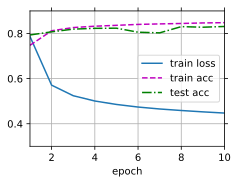

In [36]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs,updater)

### 3.6.7 预测


torch.Size([784, 10])
torch.Size([256, 784])
torch.Size([10])
tensor([[1.1820e-02, 9.8591e-03, 7.7065e-02,  ..., 2.1172e+02, 1.0250e+01,
         7.0691e+02],
        [5.6963e+00, 9.6838e-02, 9.5048e+03,  ..., 4.4981e-05, 1.8277e+00,
         2.4926e-03],
        [1.8465e+01, 2.4704e+05, 3.1687e+00,  ..., 9.3055e-02, 2.6107e-01,
         3.2205e-03],
        ...,
        [6.5333e-02, 1.7466e-01, 2.7926e-01,  ..., 9.5652e+00, 5.7328e-01,
         3.3325e+00],
        [2.0594e-01, 2.2427e-02, 2.0476e-01,  ..., 4.6951e+00, 3.1714e+01,
         9.6379e+00],
        [1.1181e+00, 1.2467e+00, 1.3507e+03,  ..., 8.6820e-05, 3.3728e+00,
         2.6898e-04]], grad_fn=<ExpBackward>)
tensor([[1.0702e+03],
        [1.1024e+04],
        [2.4710e+05],
        [8.9089e+04],
        [1.2647e+02],
        [6.6044e+03],
        [5.5322e+02],
        [2.6041e+02],
        [2.5765e+01],
        [9.9125e+02],
        [6.1669e+02],
        [1.5717e+02],
        [2.0863e+02],
        [2.5579e+03],
        [6.

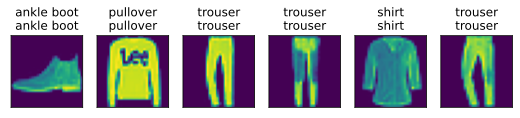

In [37]:
def predict_ch3(net, test_iter, n=6):

    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n]
    )

predict_ch3(net, test_iter)

## 3.7 通过pytorch实现softmax回归

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

C:\Users\ADRIN\Anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 3.7.1初始化模型参数
- 和手动实现一样，先将数据通过nn.Flatten()展平，相当于前面的reshape操作
- 因为分类是识别十个类别，所以在Sequential中添加一个带有十个输出的全连接层

In [2]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### 3.7.2 设置损失函数

In [3]:
loss = nn.CrossEntropyLoss()

### 3.7.3 设定学习算法
通过学习率为0.1的小批量随机梯度下降作为优化算法

In [ ]:
trainer = torch.optim.SGD()